In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns

In [2]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

### obtain the f0 features from previous results

In [4]:
data_dir = '/Users/yingli/Development/AppliedDataScience/voice_clips/'
voice_features = pd.read_csv("/Users/yingli/Development/AppliedDataScience/voice_features_f0.csv")

In [5]:
#voice_features.dropna(inplace=True)
age_names = ['teens', 'twenties','thirties', 'fourties', 
            'fifties', 'sixties', 'seventies', 'eighties']
gender_names = ["male","female"]
voice_features['age'].replace(age_names,[1,2,3,4,5,6,7,8],inplace = True)
voice_features['gender'].replace(gender_names,[0,1], inplace=True)

### adding MFCC features
* use 40 MFCC's, need to experiment what is optimal MFCC

In [6]:
mfcc_list = []
for filename in voice_features.path:
    x, sr = librosa.load(data_dir +filename, sr=None) # take the mp3's native sample rate
    x_mfcc = librosa.feature.mfcc(y=x,sr=sr,n_mfcc=40,n_mels = 128, dct_type=2)
    x_mfcc_mean = x_mfcc.mean(axis=1)
    mfcc_list.append(x_mfcc_mean)
mfcc_array = np.stack(mfcc_list,axis=0)
mfcc_features = pd.DataFrame(mfcc_array, columns=["mfcc_"+str(n).rjust(2, "0") for n in range(40)])

In [7]:
voice_features = pd.concat([mfcc_features,voice_features], axis=1)

In [8]:
zcr_list = []
for filename in voice_features.path:
    x, sr = librosa.load(data_dir +filename, sr=None) # take the mp3's native sample rate
    x_zcr = librosa.feature.zero_crossing_rate(y=x)
    x_zcr_mean = x_zcr.mean()
    zcr_list.append(x_zcr_mean)


In [9]:
voice_features.insert(0, 'zcr', zcr_list)

In [10]:
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_27', 'mfcc_28', 'mfcc_29',
       'mfcc_30', 'mfcc_31', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35',
       'mfcc_36', 'mfcc_37', 'mfcc_38', 'mfcc_39']
col_list_f0 = ['f0_mean', 'f0_variance',
       'f0_skewness', 'f0_kurtosis']
col_list_zcr = ['zcr']
col_list_full = ['zcr','mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_27', 'mfcc_28', 'mfcc_29',
       'mfcc_30', 'mfcc_31', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35',
       'mfcc_36', 'mfcc_37', 'mfcc_38', 'mfcc_39', 'f0_mean', 'f0_variance',
       'f0_skewness', 'f0_kurtosis']

In [11]:
voice_features.dropna(inplace=True)


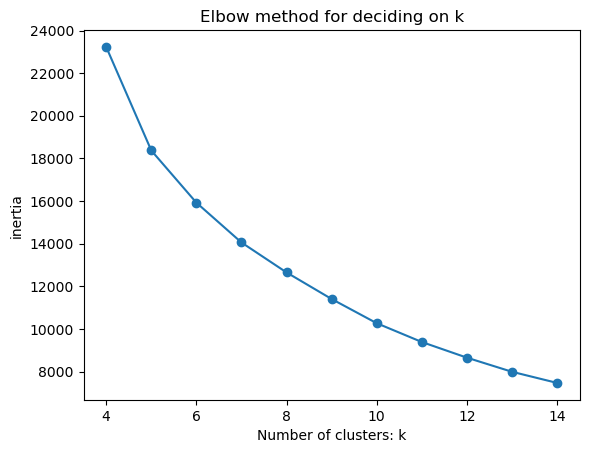

In [12]:
find_elbow(voice_features,col_list_f0,[4,5,6,7,8,9,10,11,12,13,14])

In [13]:
voice_features = run_kmeans(voice_features,col_list_mfcc, 6)
voice_features.cluster.value_counts()

3    3690
2    3040
5    2420
1    2233
0    2055
4    1549
Name: cluster, dtype: int64

In [14]:
sns.pairplot(voice_features, vars = ["f0_mean","f0_variance","f0_skewness", "f0_kurtosis", "age","gender","cluster"],hue="cluster",palette="Set1")

* MinMaxScaler seems to produce better results

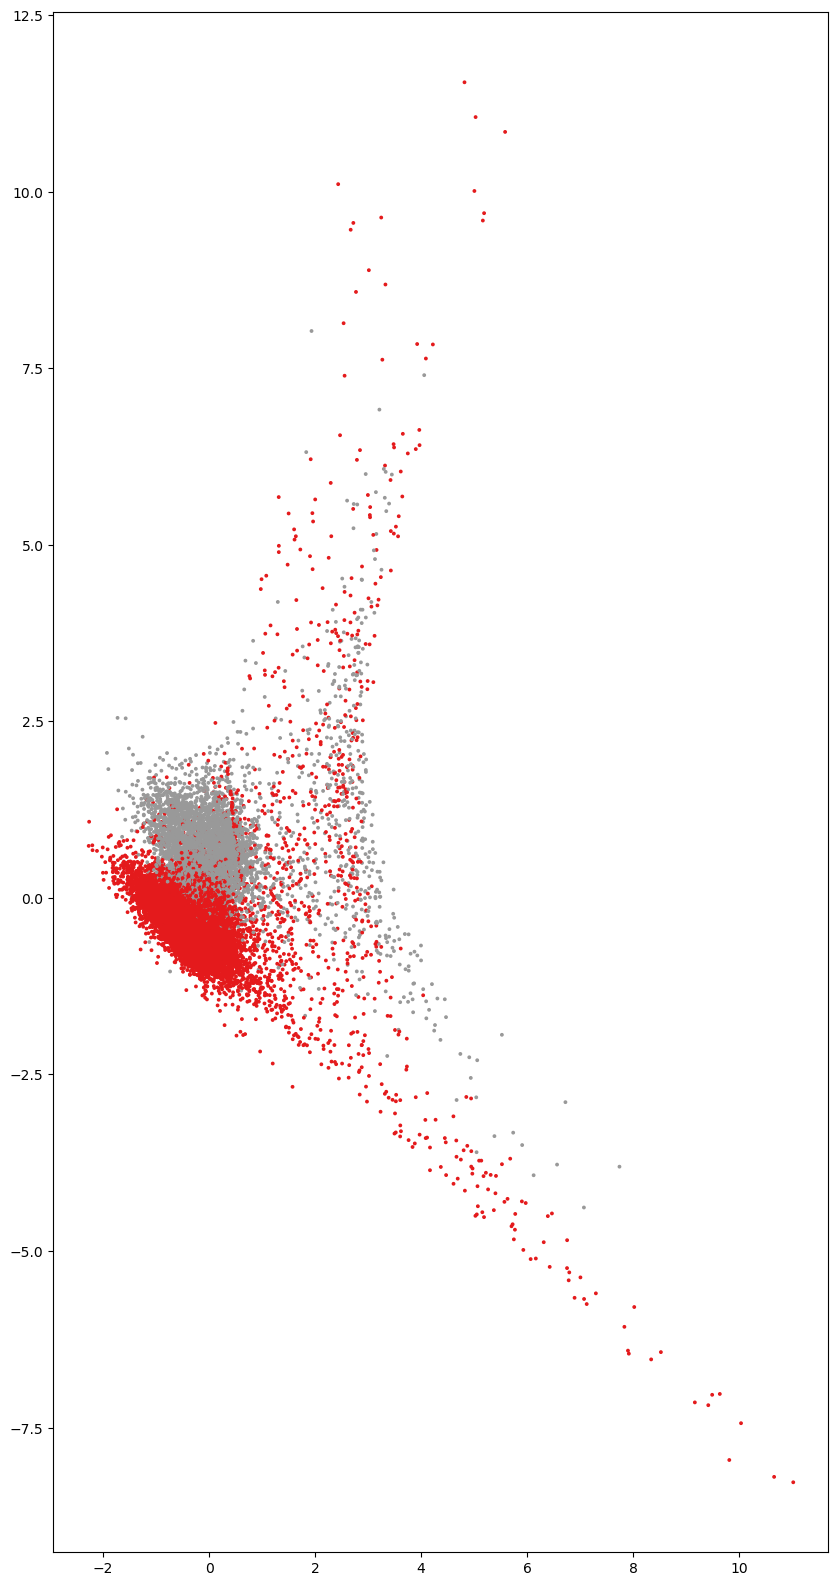

In [ ]:
X = voice_features[col_list_f0]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
X_pca = PCA(n_components="mle", svd_solver='full', whiten = True).fit_transform(X)

plt.figure(figsize=(10,20))
plt.scatter(X_pca[:,0],X_pca[:,1],c=voice_features.gender,s=3, cmap=plt.cm.Set1)


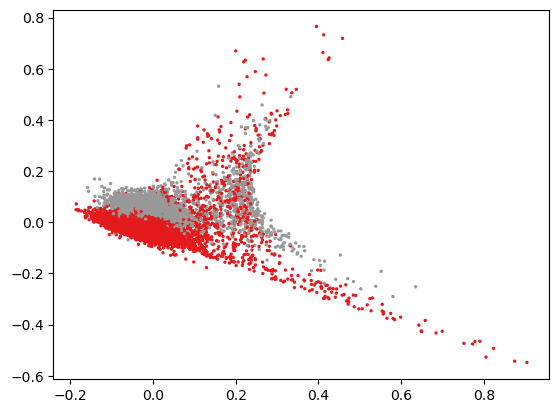

In [ ]:
col_list= ['f0_mean', 'f0_variance',
       'f0_skewness', 'f0_kurtosis']
X = voice_features[col_list]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
X_pca = PCA(n_components=3).fit_transform(X)

plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],c=voice_features.gender,s=2,cmap=plt.cm.Set1)


* tried box plot and it is not useful. 

In [ ]:
voice_features.to_csv("voice_features_20230403.csv", index=None)